In [1]:
import pandas as pd 
import folium
import os
import geohash
from folium.plugins import HeatMap

In [2]:
RESULTS_DIR = "results"
SAFECAST_DATA_PATH = os.path.join(RESULTS_DIR, '10_million_with_elevation.csv')

In [3]:
df = pd.read_csv(SAFECAST_DATA_PATH)

In [4]:
df.head()

,capture_date,latitude,longitude,value,elevation
0,2018-10-21 01:00:26.000000,36.041080,140.226816,23.0,31
1,2018-10-21 01:00:22.000000,37.796306,140.514413,19.0,72
2,2018-10-21 01:00:16.000000,37.723330,140.476797,15.0,141
3,2018-10-21 00:59:16.000000,52.444900,13.315000,16.0,47
4,2018-10-21 01:00:16.000000,37.787500,140.552400,18.0,107


In [5]:
df.shape

(9732519, 5)

In [6]:
def compute_geohash(row):
    return geohash.encode(row["latitude"], row["longitude"], precision=12)

In [7]:
df["geohash"] = df.apply(compute_geohash, axis=1)

In [8]:
df.head()

,capture_date,latitude,longitude,value,elevation,geohash
0,2018-10-21 01:00:26.000000,36.041080,140.226816,23.0,31,xn7tncn498k2
1,2018-10-21 01:00:22.000000,37.796306,140.514413,19.0,72,xnezj2x7rnh7
2,2018-10-21 01:00:16.000000,37.723330,140.476797,15.0,141,xneysek46d7w
3,2018-10-21 00:59:16.000000,52.444900,13.315000,16.0,47,u336qgr9tvzw
4,2018-10-21 01:00:16.000000,37.787500,140.552400,18.0,107,xneyyr50hk99


In [9]:
df.to_csv(os.path.join(RESULTS_DIR, "10_million_with_elevation_and_geohashes.csv"), index=False)

In [46]:
def get_geohash3(row):
    return row.geohash[:3]

df["geohash3"] = df.apply(get_geohash3, axis=1)

In [8]:
def get_geohash4(row):
    return row.geohash[:4]

df["geohash4"] = df.apply(get_geohash4, axis=1)

In [9]:
df.head()

,capture_date,latitude,longitude,value,elevation,geohash,geohash3,geohash4
0,2018-10-21 01:00:26.000000,36.041080,140.226816,23.0,31,xn7tncn498k2,xn7,xn7t
1,2018-10-21 01:00:22.000000,37.796306,140.514413,19.0,72,xnezj2x7rnh7,xne,xnez
2,2018-10-21 01:00:16.000000,37.723330,140.476797,15.0,141,xneysek46d7w,xne,xney
3,2018-10-21 00:59:16.000000,52.444900,13.315000,16.0,47,u336qgr9tvzw,u33,u336
4,2018-10-21 01:00:16.000000,37.787500,140.552400,18.0,107,xneyyr50hk99,xne,xney


In [14]:
counts_in_geohash = df[["geohash4", "value"]].groupby("geohash4").count().reset_index().rename(index=str, columns={"geohash4": "geohash"})
counts_in_geohash.head()

,geohash,value
0,6mc4,7
1,6mc5,524
2,6mse,712
3,6msg,1288
4,6msk,251


In [44]:
def visualize_counts_with_folium(df):
    m = folium.Map(location=[37.760806, 140.474722], zoom_start=10)
    max_val = df.value.max()
    quantiles = [0, 0.02, 0.05, 0.1, 0.2]

    m.choropleth(
        geo_data=get_geo_data(df),
        name='choropleth',
        data=df,
        columns=['geohash', 'value'],
        key_on='feature.id',
        fill_color='YlOrRd',
        fill_opacity=0.9,
        line_opacity=0.2,
        legend_name='Number of measurements',
        threshold_scale=[quantile * max_val for quantile in quantiles]
    )
    folium.LayerControl().add_to(m)
    return m

In [45]:
m = visualize_counts_with_folium(counts_in_geohash)

In [46]:
m

In [47]:
m.save(os.path.join(RESULTS_DIR, "measuerements_counts.html"))

In [48]:
len(counts_in_geohash)

4386

In [12]:
points_in_smallest_geohashes = df.geohash.value_counts()
points_in_smallest_geohashes[:10]

xn7tncn498k2    186517
dr085nmgm9uf    104446
u336qgr9tvzw     89549
drt3jg3bes1u     76057
c22yzgx19fnc     76016
xnsm8qju2h08     76015
xneutf7sbunj     75907
9qbdmpnm61xh     75900
xns78x3f2wrd     75877
xn76guj02weq     75823
Name: geohash, dtype: int64

In [13]:
points_in_smallest_geohashes.mean()

2.335187883583703

In [14]:
points_in_geohashes_precision_3 = df.geohash3.value_counts()
points_in_geohashes_precision_3[:10]

xne    983415
xns    829514
xn7    794897
drt    331623
9q5    289635
xn0    254543
u0y    241994
c20    230505
u2f    207175
u1k    190299
Name: geohash3, dtype: int64

In [15]:
points_in_geohashes_precision_3.mean()

16467.883248730963

In [47]:
grouped_cor = (
    df[["geohash3", "value", "elevation"]]
    .groupby("geohash3")
    .corr()
    .iloc[0::2,-1]
    .to_frame()
    .reset_index()
    .rename(index=str, columns={"geohash3": "geohash"})
)[['geohash', 'value']]
grouped_cor.head()

,geohash,value
0,6mc,0.442441
1,6ms,0.259028
2,6nr,NaN
3,6nx,NaN
4,6ny,NaN


In [48]:
grouped_cor_filtered = grouped_cor[grouped_cor["value"].notna()]

In [49]:
grouped_cor_filtered.head()

,geohash,value
0,6mc,0.442441
1,6ms,0.259028
10,9fx,-0.006181
12,9mu,-0.001871
15,9pz,0.040149


In [50]:
def get_middle(row):
    return pd.Series(geohash.decode(row.geohash))

grouped_cor_filtered[["latitude", "longitude"]] = grouped_cor_filtered.apply(get_middle, axis=1)

e:\anaconda\lib\site-packages\pandas\core\frame.py:3140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [51]:
grouped_cor_filtered.head()

,geohash,value,latitude,longitude
0,6mc,0.442441,-11.953125,-76.640625
1,6ms,0.259028,-13.359375,-72.421875
10,9fx,-0.006181,14.765625,-90.703125
12,9mu,-0.001871,33.046875,-117.421875
15,9pz,0.040149,44.296875,-124.453125


In [25]:
grouped_cor_filtered["value"] += 1
grouped_cor_filtered.head()

e:\anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,geohash,value,latitude,longitude
0,6mc,1.442441,-11.953125,-76.640625
1,6ms,1.259028,-13.359375,-72.421875
10,9fx,0.993819,14.765625,-90.703125
12,9mu,0.998129,33.046875,-117.421875
15,9pz,1.040149,44.296875,-124.453125


In [26]:
hmap = folium.Map(location=[37.7503, 140.4676], zoom_start=7, )

hm_wide = HeatMap( list(zip(grouped_cor_filtered.latitude.values, grouped_cor_filtered.longitude.values, grouped_cor_filtered.value.values)),
                   min_opacity=0.001,
                   max_val=2,
                   radius=17, blur=15, 
                   max_zoom=1, 
                 )

hmap.add_child(hm_wide)

In [27]:
hmap.save(os.path.join(RESULTS_DIR, "10_million_heatmap_without_geohashes.html"))

In [53]:
geohash_df = grouped_cor_filtered[["geohash", "value"]]

In [ ]:
geohash_df["value"] -= 1

In [54]:
geohash_df.head()

,geohash,value
0,6mc,0.442441
1,6ms,0.259028
10,9fx,-0.006181
12,9mu,-0.001871
15,9pz,0.040149


In [55]:
def get_coordinates(geo):
    bbox = geohash.bbox(geo)
    return [[bbox["w"], bbox["n"]], [bbox["e"], bbox["n"]], [bbox["e"], bbox["s"]], [bbox["w"], bbox["s"]]]

def get_geo_data(ghash_df):
    features = []

    for geo, _ in ghash_df.values:
        features.append({"type": "Feature", "id": geo, 
                         "geometry": {"type": "Polygon", "coordinates": [get_coordinates(geo)]}})

    return {"type": "FeatureCollection", "features": features}

In [90]:
def visualize_correlation_with_folium(df):
    m = folium.Map(location=[37.760806, 140.474722], zoom_start=3)

    # Add the color for the choropleth:
    m.choropleth(
        geo_data=get_geo_data(df),
        name='choropleth',
        data=df,
        columns=['geohash', 'value'],
        key_on='feature.id',
        fill_color='YlOrRd',
        fill_opacity=0.7,
        line_opacity=0.2,
        legend_name='Correlation between elevation and radiation',
        threshold_scale=[-0.95, -0.65, 0, 0.65, 0.95]
    )
    folium.LayerControl().add_to(m)
    return m

In [91]:
m = visualize_correlation_with_folium(geohash_df)

In [92]:
m

In [93]:
m.save(os.path.join(RESULTS_DIR, "10_million_heatmap_with_geohashes.html"))

In [116]:
def plot_elevation_and_radiation_for_geohash(ghash):
    df_for_random_geohash = df[df.geohash3 == ghash]
    std_dev = df_for_random_geohash.elevation.std()
    plot = df_for_random_geohash.plot.scatter(x="value", y="elevation", title=f"geohash {ghash}, std dev={round(std_dev, 2)}")
    plot.get_figure().savefig(os.path.join(RESULTS_DIR, f"{ghash}_elevation_value_plot.png"))

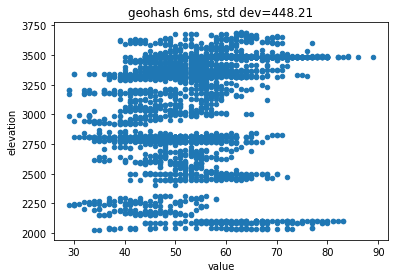

In [117]:
plot_elevation_and_radiation_for_geohash("6ms")

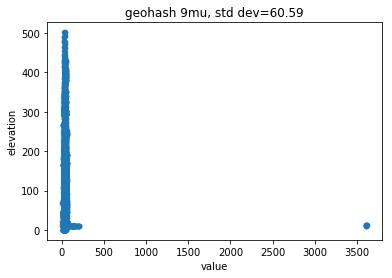

In [118]:
plot_elevation_and_radiation_for_geohash("9mu")

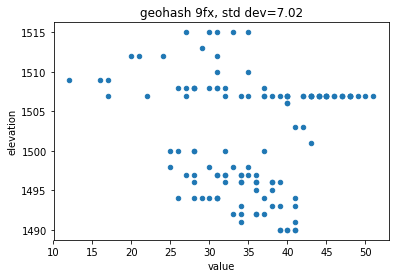

In [119]:
plot_elevation_and_radiation_for_geohash("9fx")

In [98]:
minimum_std_dev = 20
g_df = df[["geohash3", "elevation"]].groupby("geohash3").std()
geohashes = g_df[g_df.elevation >= minimum_std_dev].index
geohashes[:10]

Index(['6mc', '6ms', '9mu', '9pz', '9q3', '9q4', '9q5', '9q6', '9q8', '9q9'], dtype='object', name='geohash3')

In [99]:
grouped_cor_2 = (
    df[["geohash3", "value", "elevation"]]
    .groupby("geohash3")
    .corr()
    .iloc[0::2,-1]
    .to_frame()
    .reset_index()
    .rename(index=str, columns={"geohash3": "geohash"})
)[['geohash', 'value']]
grouped_cor_filtered2 = grouped_cor_2[grouped_cor_2["value"].notna()]
grouped_cor_filtered2 = grouped_cor_filtered2[grouped_cor_filtered2.geohash.isin(geohashes)]
grouped_cor_filtered2[["latitude", "longitude"]] = grouped_cor_filtered2.apply(get_middle, axis=1)
grouped_cor_filtered2.head()
geohash_df2 = grouped_cor_filtered2[["geohash", "value"]]
geohash_df2.head()

,geohash,value
0,6mc,0.442441
1,6ms,0.259028
12,9mu,-0.001871
15,9pz,0.040149
16,9q3,-0.115880


In [100]:
m2 = visualize_correlation_with_folium(geohash_df2)

In [102]:
m2

In [101]:
m2.save(os.path.join(RESULTS_DIR, "10_million_heatmap_with_geohashes_filtered.html"))

In [132]:
smallest = geohash_df2.nsmallest(15, columns="value")
smallest

,geohash,value
578,ycn,-0.878722
466,u3e,-0.791788
548,x4q,-0.587522
482,u6e,-0.543754
308,spe,-0.530981
504,ud9,-0.472631
575,ybz,-0.467207
206,evc,-0.461805
128,c88,-0.448535
217,eyv,-0.431546


In [127]:
largest = geohash_df2.nlargest(1, columns="value")
largest

,geohash,value
328,srg,0.970125


In [130]:
m3 = visualize_correlation_with_folium(pd.concat([smallest, largest]))
m3

In [131]:
m3.save(os.path.join(RESULTS_DIR, "smallest_and_largest_correlation.html"))